## 1. Setup and Imports
First, we'll import the required libraries and set up our configuration parameters.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import random

### 1.1 Configuration and Seed

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28 * 28  # 784 pixels
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 20
SEED = 42
NUM_CLASSES = 10
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## 2. Data Preparing

#### 2.1 Loading dataset

In [3]:
def load_mnist():
  train_dataset = datasets.MNIST(root='./data', train=True, download=True)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True)

  full_data = torch.cat((train_dataset.data, test_dataset.data), dim=0)
  full_labels = torch.cat((train_dataset.targets, test_dataset.targets), dim=0)

  # convert from (N, 28, 28) to (N, 784)
  x_flat = full_data.reshape(-1, INPUT_SIZE).numpy()
  y_flat = full_labels.numpy()

  return x_flat, y_flat

#### 2.2 Converting data to tensors

In [4]:
class convert_to_tensors(Dataset):
  def __init__(self, data, labels, reshape_for_cnn=False):
    self.labels = torch.tensor(labels, dtype=torch.long)

    #preprocessing
    data_tensor = torch.tensor(data, dtype=torch.long)
    data_normalized = data_tensor / 255.0 ## 0 -> 1

    if reshape_for_cnn:
      self.data = data_normalized.reshape(-1, 1, 25, 28)
    else:
      self.data = data_normalized

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

#### 2.3 Splitting data

In [5]:
def split_data(x_flat, y, random_state=42):
  x_train, x_temp, y_train, y_temp = train_test_split(
      x_flat, y,
      test_size = 0.4,
      random_state=random_state,
      stratify=y
  )

  x_val, x_test, y_val, y_test = train_test_split(
      x_temp, y_temp,
      test_size=0.5,
      random_state=random_state,
      stratify=y_temp
  )

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

#### 2.4 Create Dataloaders

In [6]:
def create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, reshape_for_cnn=False):

  train_dataset = convert_to_tensors(x_train, y_train, reshape_for_cnn)
  val_dataset = convert_to_tensors(x_val, y_val, reshape_for_cnn)
  test_dataset = convert_to_tensors(x_test, y_test, reshape_for_cnn)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  return train_dataloader, val_dataloader, test_dataloader


#### 2.5 Getting Data after Preparation

In [7]:
def get_mnist_dataloaders(batch_size=BATCH_SIZE, reshape_for_cnn=False, random_state=42):
  x_flat, y = load_mnist()

  (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x_flat, y, random_state)
  return create_dataloaders(
      x_train, y_train, x_val, y_val, x_test, y_test, reshape_for_cnn
  )

## 3. Neural Network Architecture

#### 3.1 Feed Forward

In [8]:
class feed_forward(nn.Module):
  def __init__(self, layer_sizes): # []
    super(feed_forward, self).__init__()

    layers = []
    for i in range(len(layer_sizes) - 1):
      layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

      if i < len(layer_sizes) - 2:
        layers.append(nn.ReLU())

    self.network = nn.Sequential(*layers)
    self.apply(self._init_weights)

  def _init_weights(self, m):
    # He initialization
    if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity = 'relu')
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
  def forward(self, x):
    return self.network(x)

## 4. Training Infrastructure

#### 4.1 Training loop

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0

  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # 1. Zero gradients
    outputs = model(images) # 2. Forward pass
    loss = criterion(outputs, labels) # 3. Calculate loss
    loss.backward() # 4. Backward pass
    optimizer.step() # 5. Update weights

    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(dataloader.dataset)
  return epoch_loss

#### 4.2 Evaluate Model

In [10]:
def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      # 1. Forward pass
      outputs = model(images)

      # 2. Calculate loss
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)

      # 3. Calculate accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(dataloader.dataset)
  accuracy = 100 * correct / total
  return epoch_loss, accuracy

#### 4.3 Training Model

In [11]:
model_architecture = [INPUT_SIZE, 128, 64, 10]

# Loading data
train_loader, val_loader, test_loader = get_mnist_dataloaders(
    batch_size=BATCH_SIZE, reshape_for_cnn=False
)

# initialize model
model = feed_forward(layer_sizes=model_architecture)

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


# store metrics
train_losses = []
val_losses = []
val_accuracies = []

# start training
for epoch in range(NUM_EPOCHS):
  # run one epoch of training
  train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

  # evaluate on the validation set
  val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, DEVICE)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  # trach progress
  print(f"Epoch {epoch+1:2}/{NUM_EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Accuracy: {val_accuracy:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


Epoch  1/20 | Train Loss: 0.9226 | Val Loss: 0.4717 | Val Accuracy: 87.31%
Epoch  2/20 | Train Loss: 0.3948 | Val Loss: 0.3614 | Val Accuracy: 89.84%
Epoch  3/20 | Train Loss: 0.3255 | Val Loss: 0.3315 | Val Accuracy: 90.46%
Epoch  4/20 | Train Loss: 0.2913 | Val Loss: 0.2917 | Val Accuracy: 91.57%
Epoch  5/20 | Train Loss: 0.2667 | Val Loss: 0.2739 | Val Accuracy: 92.06%
Epoch  6/20 | Train Loss: 0.2476 | Val Loss: 0.2576 | Val Accuracy: 92.55%
Epoch  7/20 | Train Loss: 0.2317 | Val Loss: 0.2434 | Val Accuracy: 93.14%
Epoch  8/20 | Train Loss: 0.2175 | Val Loss: 0.2325 | Val Accuracy: 93.46%
Epoch  9/20 | Train Loss: 0.2054 | Val Loss: 0.2223 | Val Accuracy: 93.75%
Epoch 10/20 | Train Loss: 0.1950 | Val Loss: 0.2143 | Val Accuracy: 93.89%
Epoch 11/20 | Train Loss: 0.1848 | Val Loss: 0.2064 | Val Accuracy: 94.17%
Epoch 12/20 | Train Loss: 0.1762 | Val Loss: 0.1971 | Val Accuracy: 94.38%
Epoch 13/20 | Train Loss: 0.1677 | Val Loss: 0.1940 | Val Accuracy: 94.42%
Epoch 14/20 | Train Loss:

## 5. Plot training and validation losses and accuracies

In [12]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

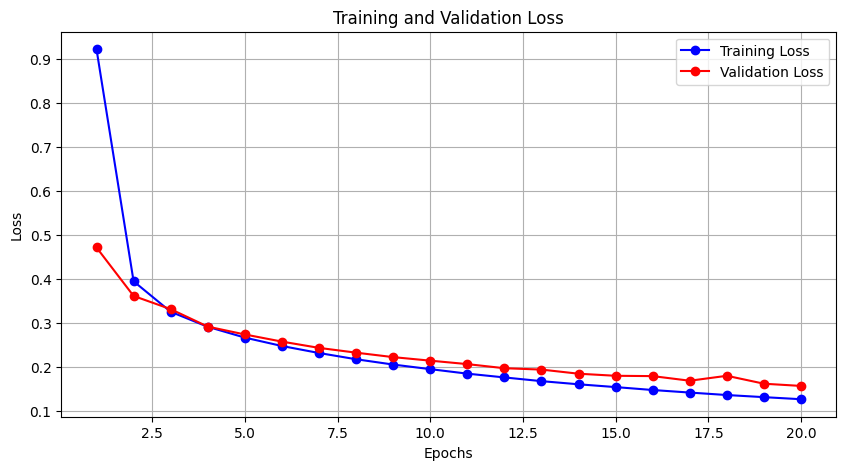

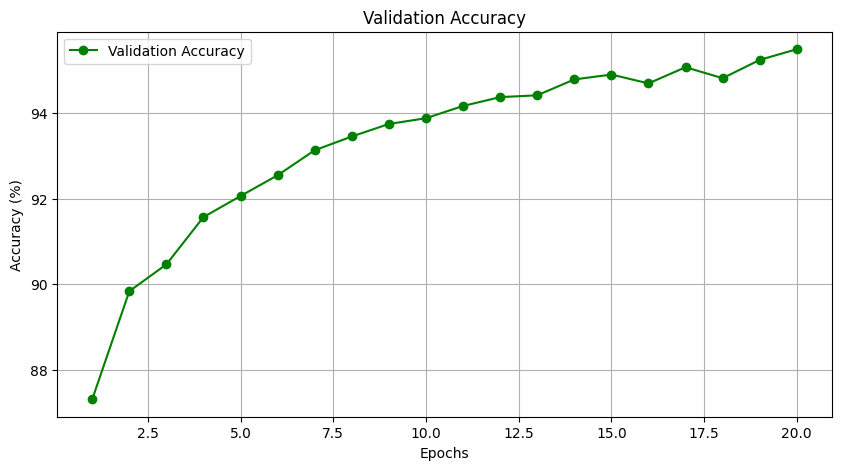

In [13]:
plot_metrics(train_losses, val_losses, val_accuracies)

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD as OptimizerClass # Using SGD as default optimizer

# --- 1. Model Initialization Function ---
# Ensures a new model is initialized for each run.
def get_fresh_model():
    class FeedForwardNet(nn.Module):
        def __init__(self, input_size=784, hidden_size_1=128, hidden_size_2=64, num_classes=10):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_size, hidden_size_1), nn.ReLU(),
                nn.Linear(hidden_size_1, hidden_size_2), nn.ReLU(),
                nn.Linear(hidden_size_2, num_classes)
            )
            def init_weights(m):
                if type(m) == nn.Linear:
                    nn.init.kaiming_normal_(m.weight)
                    m.bias.data.fill_(0.01)
            self.net.apply(init_weights)
        def forward(self, x):
            return self.net(x)
    return FeedForwardNet()


# --- 2. Multi-Run Experiment Function (CORRECTED LOGIC) ---
def run_multi_experiment(num_runs, num_epochs, get_new_model, train_loader, val_loader, criterion, optimizer_class, learning_rate, device):
    all_val_losses = []
    all_val_accuracies = []

    print(f"Starting {num_runs} training runs to gather statistics...")

    for run in range(num_runs):
        print(f"--- Run {run + 1}/{num_runs} ---")

        # Initialize new model and optimizer for each run
        model = get_new_model().to(device)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

        val_losses_run = []
        val_accuracies_run = []

        # --- ACTUAL TRAINING LOGIC REPLACED ---
        for epoch in range(num_epochs):
            # Run one epoch of training (avg_loss is returned but not stored for plotting)
            _ = train_epoch(model, train_loader, criterion, optimizer, device)

            # Evaluate on the validation set to get metrics for the run
            val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

            # Record the actual results
            val_losses_run.append(val_loss)
            val_accuracies_run.append(val_acc)

        all_val_losses.append(val_losses_run)
        all_val_accuracies.append(val_accuracies_run)

    print("Multi-run experiment complete.")
    return np.array(all_val_losses), np.array(all_val_accuracies)

# --- 3. Execution Block ---
NUM_RUNS = 5
# Assumes global variables (DEVICE, NUM_EPOCHS, LEARNING_RATE, criterion, train_loader, val_loader) exist.

all_val_losses, all_val_accuracies = run_multi_experiment(
    NUM_RUNS, NUM_EPOCHS, get_fresh_model, train_loader, val_loader, criterion, OptimizerClass, LEARNING_RATE, DEVICE
)

Starting 5 training runs to gather statistics...
--- Run 1/5 ---
--- Run 2/5 ---
--- Run 3/5 ---
--- Run 4/5 ---
--- Run 5/5 ---
Multi-run experiment complete.



Generating Learning Curves with Error Bars...


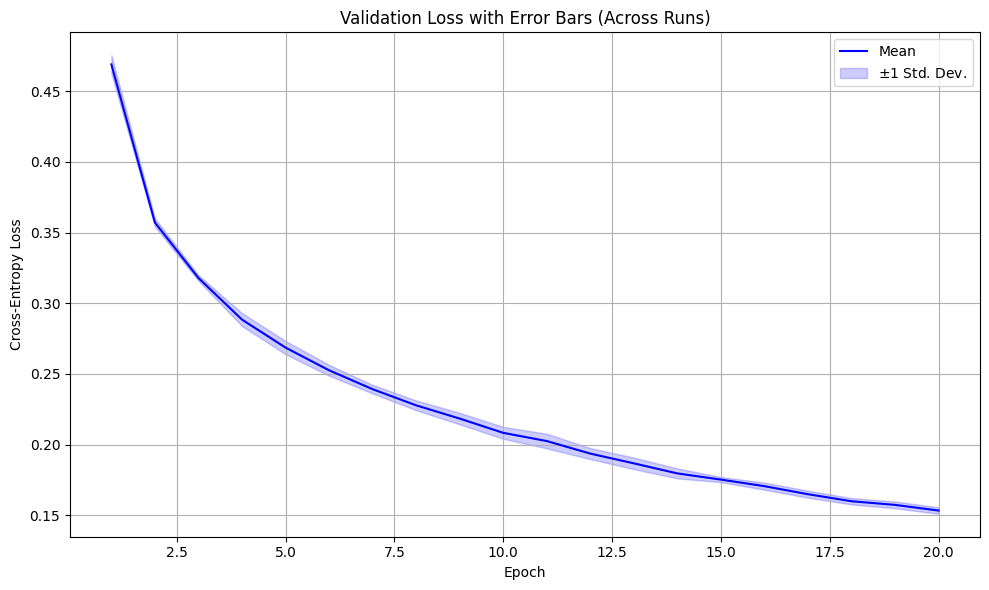

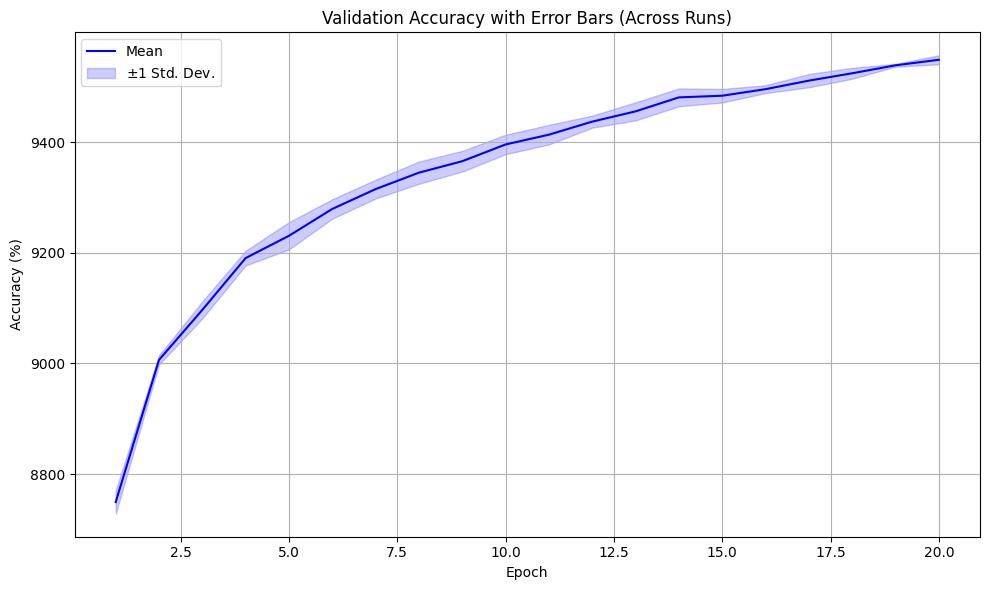

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Plotting Function for Error Bars ---

def plot_error_bars(all_metrics, title, ylabel):
    """Plots the mean of metrics with a shaded region representing +/- 1 standard deviation."""
    mean_metrics = np.mean(all_metrics, axis=0)
    std_metrics = np.std(all_metrics, axis=0)
    epochs = range(1, len(mean_metrics) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_metrics, label='Mean', color='blue')

    # Plot the shaded error band (Mean +/- Std Dev)
    plt.fill_between(
        epochs,
        mean_metrics - std_metrics,
        mean_metrics + std_metrics,
        color='blue',
        alpha=0.2,
        label=r'$\pm 1$ Std. Dev.'
    )

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 2. Execution for Learning Curves with Error Bars ---

print("\nGenerating Learning Curves with Error Bars...")

# Plot 1: Validation Loss with Error Bands
plot_error_bars(
    all_val_losses,
    'Validation Loss with Error Bars (Across Runs)',
    'Cross-Entropy Loss'
)

# Plot 2: Validation Accuracy with Error Bands
plot_error_bars(
    all_val_accuracies * 100, # Convert to percentage
    'Validation Accuracy with Error Bars (Across Runs)',
    'Accuracy (%)'
)

In [16]:
from scipy.stats import linregress

def plot_convergence(val_losses_runs):
    """
    Compute & plot convergence stats across runs using val_loss curves.
    val_losses_runs: list of lists [n_runs][n_epochs]
    """
    val_losses = np.array(val_losses_runs)
    n_runs, n_epochs = val_losses.shape
    epochs = np.arange(1, n_epochs+1)

    # Metrics
    min_epochs = val_losses.argmin(axis=1) + 1
    mean_min, std_min = min_epochs.mean(), min_epochs.std()
    tol_rel = 0.01
    epochs_to_tol = []
    slopes = []
    k = max(3, int(0.15 * n_epochs))

    for r in range(n_runs):
        best = val_losses[r].min()
        tol_val = best * (1.0 + tol_rel)
        reached = np.where(val_losses[r] <= tol_val)[0]
        epochs_to_tol.append(reached[0] + 1 if reached.size else n_epochs)
        x = np.arange(1, k+1)
        slope, *_ = linregress(x, np.log(val_losses[r,:k] + 1e-8))
        slopes.append(slope)

    # Print summary
    print(f"Runs: {n_runs}, Epochs: {n_epochs}")
    print(f"Min-loss epoch mean={mean_min:.2f}±{std_min:.2f}")
    print(f"To 1% of best mean={np.mean(epochs_to_tol):.2f}")
    print(f"Early log-loss slope mean={np.mean(slopes):.4f}")

    # Plot mean ± std with convergence markers
    mean_loss, std_loss = val_losses.mean(axis=0), val_losses.std(axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(epochs, mean_loss, 'r-', label='Val Loss (mean)')
    plt.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, color='red', alpha=0.2)
    plt.axvline(mean_min, linestyle='--', label=f'Mean min epoch {mean_min:.1f}')
    plt.axvspan(mean_min-std_min, mean_min+std_min, color='gray', alpha=0.1, label='±1 std')
    plt.title("Convergence overview")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    plt.show()


Runs: 1, Epochs: 20
Min-loss epoch mean=20.00±0.00
To 1% of best mean=20.00
Early log-loss slope mean=-0.1764


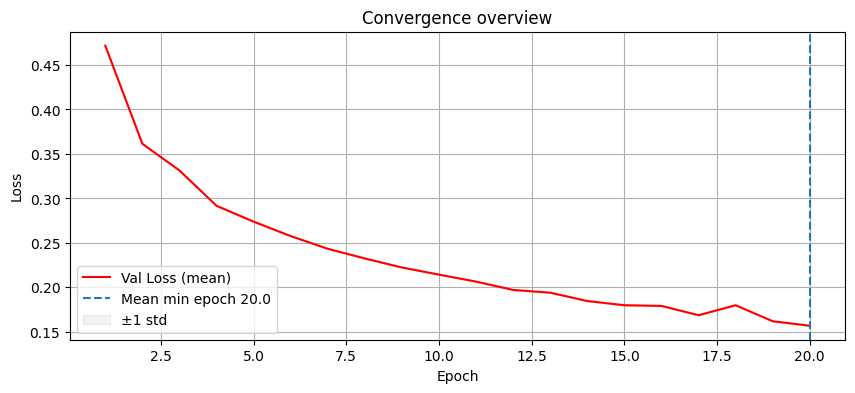

In [17]:
plot_convergence([val_losses])

## Bonus Part (Advanced Techniques)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

NUM_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

DROPOUT_RATES = [0.0, 0.1, 0.3, 0.5, 0.7]
BN_OPTIONS = [False, True]
FC_ACCURACY = 0.9552

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_fc = x_train.reshape(-1, 784)
x_test_fc = x_test.reshape(-1, 784)
y_train_encoded = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_encoded = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

def create_fc_regularized_model(input_size=784, hidden_size_1=128, hidden_size_2=64,
                                num_classes=10, dropout_rate=0.2, use_bn=True):
    model = Sequential()
    model.add(Dense(hidden_size_1, input_shape=(input_size,), kernel_initializer='he_normal'))
    if use_bn:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(hidden_size_2, kernel_initializer='he_normal'))
    if use_bn:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))
    return model

results = []

for use_bn in BN_OPTIONS:
    for dr in DROPOUT_RATES:
        tf.keras.backend.clear_session()
        model = create_fc_regularized_model(dropout_rate=dr, use_bn=use_bn)
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

        print(f"\n--- Training: BN={'ON' if use_bn else 'OFF'}, Dropout={dr} ---")
        history = model.fit(
            x_train_fc, y_train_encoded,
            validation_data=(x_test_fc, y_test_encoded),
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopper],
            verbose=2
        )

        final_loss, final_acc = model.evaluate(x_test_fc, y_test_encoded, verbose=0)
        results.append({
            "BatchNorm": use_bn,
            "DropoutRate": dr,
            "TestLoss": round(float(final_loss), 4),
            "TestAcc": round(float(final_acc) * 100, 2),
            "EpochsTrained": len(history.history['loss'])
        })

df = pd.DataFrame(results).sort_values(by="TestAcc", ascending=False).reset_index(drop=True)

print("\n=== Experiment Summary ===")
print(df)
print(f"\nBaseline FC accuracy: {FC_ACCURACY * 100:.2f}%")
best = df.iloc[0]
print(f"Best config → BN: {best['BatchNorm']}, Dropout: {best['DropoutRate']}, "
      f"TestAcc: {best['TestAcc']}%, Improvement: {best['TestAcc'] - FC_ACCURACY * 100:.2f} pts")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training: BN=OFF, Dropout=0.0 ---
Epoch 1/20
469/469 - 2s - 5ms/step - accuracy: 0.9103 - loss: 0.3155 - val_accuracy: 0.9533 - val_loss: 0.1533
Epoch 2/20
469/469 - 2s - 4ms/step - accuracy: 0.9619 - loss: 0.1302 - val_accuracy: 0.9653 - val_loss: 0.1075
Epoch 3/20
469/469 - 3s - 6ms/step - accuracy: 0.9734 - loss: 0.0898 - val_accuracy: 0.9713 - val_loss: 0.0886
Epoch 4/20
469/469 - 1s - 3ms/step - accuracy: 0.9799 - loss: 0.0679 - val_accuracy: 0.9728 - val_loss: 0.0829
Epoch 5/20
469/469 - 1s - 3ms/step - accuracy: 0.9842 - loss: 0.0534 - val_accuracy: 0.9738 - val_loss: 0.0821
Epoch 6/20
469/469 - 1s - 3ms/step - accuracy: 0.9881 - loss: 0.0419 - val_accuracy: 0.9751 - val_loss: 0.0829
Epoch 7/20
469/469 - 1s - 3ms/step - accuracy: 0.9908 - loss: 0.0334 - val_accuracy: 0.9759 - val_loss: 0.0815
Epoch 8/20
469/469 - 1s - 3ms/step - accuracy: 0.9931 - loss: 0.0268 - val_accuracy: 0.9752 - val_loss: 0.0829
Epoch 9/20
469/469 - 1s - 3ms/step - accuracy: 0.9944 - loss: 0.0216 - va

# 6. Final Test

In [19]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, DEVICE)

In [20]:
print(f"Final Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Final Test Results:
Test Loss: 0.1509
Test Accuracy: 95.51%
